<a href="https://colab.research.google.com/github/Mehedi16009/BreastCancer-ViTRegNet-XAI/blob/main/5th_August_Breast_Cancer_Classifier_with_ViT%2C_RegNet%2C_GradCAM_%26_SHAP_%E2%80%94_Complete_Pipeline_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline Summary & Architecture
# 1. Data Preparation
Loaded mammogram JPEG images paired with metadata labels (benign/malignant).

Images resized to 224×224 pixels and normalized.

Dataset split into train/validation/test with class balance.

# 2. Modeling
Utilized Vision Transformer (ViT-Small, ViT-Medium, ViT-Large) and RegNetY-064 CNN architectures from the timm library.

Models pretrained on ImageNet, fine-tuned for breast cancer classification (2 classes).

Fusion model option: concatenates ViT and RegNet features before classification.

# 3. Training Pipeline
Used PyTorch Lightning (optional) for clean training loops.

Optimizer: AdamW; scheduler: Cosine Annealing.

Metrics tracked: Accuracy, F1 Score, Precision, Recall, AUC.

# 4. Explainability
Integrated GradCAM to generate heatmaps indicating which image regions the model focuses on.

For ViT, applied a reshape_transform to convert patch embeddings into spatial maps GradCAM expects.

For RegNet, directly used last convolutional block.

Applied SHAP (via Captum) for feature importance and interpretability.

Saved and visualized GradCAM overlays to analyze model attention on mammograms.

# 5. Outputs
Model performance metrics and ROC/AUC curves.

GradCAM heatmaps overlaid on mammograms for qualitative explainability.

(Optional) Fusion model combining ViT + RegNet features for enhanced performance.


**Dataset Link:** https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset?resource=download

In [ ]:
# @title Start:

In [ ]:
# @title 1. Setup and Data Loading (Metadata)
1.1 Mount Google Drive and Load CSVs
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
mass_df = pd.read_csv('/content/drive/MyDrive/archive/csv/mass_case_description_train_set.csv')
calc_df = pd.read_csv('/content/drive/MyDrive/archive/csv/calc_case_description_train_set.csv')
meta_df = pd.read_csv('/content/drive/MyDrive/archive/csv/meta.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title 1.2 Load and Match Images with Metadata
import os
from PIL import Image

base_dir = '/content/drive/MyDrive/archive/jpeg/'
image_records = []
for patient_id in os.listdir(base_dir):
    patient_dir = os.path.join(base_dir, patient_id)
    if os.path.isdir(patient_dir):
        for img_name in os.listdir(patient_dir):
            if img_name.lower().endswith('.jpg'):
                img_path = os.path.join(patient_dir, img_name)
                case_id = os.path.splitext(img_name)[0]  # extract ID without extension
                # Lookup pathology label from CSVs:
                if case_id in mass_df['image file path'].values:
                    label = mass_df.loc[mass_df['image file path']==case_id, 'pathology'].item()
                elif case_id in calc_df['image file path'].values:
                    label = calc_df.loc[calc_df['image file path']==case_id, 'pathology'].item()
                else:
                    continue
                image_records.append((img_path, label))


In [ ]:
# @title 1.3 Image Resizing and Normalization
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
# Usage example: tensor_img = transform(PIL.Image.open(img_path))


In [ ]:
# @title 1.3.1 Debug Info
print("Sample image filename:", img_name)
print("Looking for case ID:", case_id)
print("mass_df sample paths:", mass_df['image file path'].head())


Sample image filename: 1-191.jpg
Looking for case ID: 1-191
mass_df sample paths: 0    Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...
1    Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...
2    Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...
3    Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...
4    Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...
Name: image file path, dtype: object


In [ ]:
# @title 1.3.2 Match by Partial Filename
for patient_id in os.listdir(base_dir):
    patient_dir = os.path.join(base_dir, patient_id)
    if os.path.isdir(patient_dir):
        for img_name in os.listdir(patient_dir):
            if img_name.lower().endswith('.jpg'):
                img_path = os.path.join(patient_dir, img_name)
                # match any CSV row whose image file path is contained in filename
                matched_mass = mass_df[mass_df['image file path'].str.contains(img_name.split('.')[0])]
                matched_calc = calc_df[calc_df['image file path'].str.contains(img_name.split('.')[0])]

                if not matched_mass.empty:
                    label = matched_mass.iloc[0]['pathology']
                elif not matched_calc.empty:
                    label = matched_calc.iloc[0]['pathology']
                else:
                    continue
                image_records.append((img_path, label))


In [ ]:
# @title 1.3.3 Fix the matching logic:
import os
from PIL import Image

base_dir = '/content/drive/MyDrive/archive/jpeg'
image_records = []

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        for img_name in os.listdir(folder_path):
            if img_name.lower().endswith('.jpg'):
                img_path = os.path.join(folder_path, img_name)
                # Check if folder name exists in image file path of mass or calc CSV
                matched_mass = mass_df[mass_df['image file path'].str.contains(folder)]
                matched_calc = calc_df[calc_df['image file path'].str.contains(folder)]

                if not matched_mass.empty:
                    label = matched_mass.iloc[0]['pathology']
                elif not matched_calc.empty:
                    label = matched_calc.iloc[0]['pathology']
                else:
                    continue

                image_records.append((img_path, label))


In [ ]:
print("Total matched images:", len(image_records))
print("Sample record:", image_records[0])


Total matched images: 2458
Sample record: ('/content/drive/MyDrive/archive/jpeg/1.3.6.1.4.1.9590.100.1.2.71928301212219609314072252602966948877/1-081.jpg', 'BENIGN_WITHOUT_CALLBACK')


In [ ]:
# @title 1.4 Now The Train/Val/Test split:
from sklearn.model_selection import train_test_split

paths = [rec[0] for rec in image_records]
labels = [1 if rec[1].lower() == 'malignant' else 0 for rec in image_records]  # Normalize labels to 0/1

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    paths, labels, test_size=0.2, random_state=42, stratify=labels)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)


In [ ]:
# @title STEP 2: DataLoader + Custom Dataset Setup (Colab + PyTorch Lightning)


We'll:

Create a custom MammogramDataset

Apply transforms (resizing, normalization, and optional augmentation)

Build DataLoader for train/val/test splits

In [ ]:
# @title 2.1 Install and Import Dependencies
!pip install -q albumentations timm pytorch-lightning torchmetrics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 839.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.2 MB/s eta 0:00:00


In [ ]:

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

In [ ]:
# @title 🧱 2.2 Custom Dataset Class
class MammogramDataset(Dataset):
    def __init__(self, image_paths, labels, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.augment = augment

        self.train_transforms = A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Rotate(limit=10, p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

        self.val_transforms = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Open image
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        if self.augment:
            image = self.train_transforms(image=image)['image']
        else:
            image = self.val_transforms(image=image)['image']

        return image, torch.tensor(label, dtype=torch.long)


In [ ]:
# @title 2.3 Create DataLoaders
BATCH_SIZE = 32

train_dataset = MammogramDataset(train_paths, train_labels, augment=True)
val_dataset   = MammogramDataset(val_paths, val_labels, augment=False)
test_dataset  = MammogramDataset(test_paths, test_labels, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


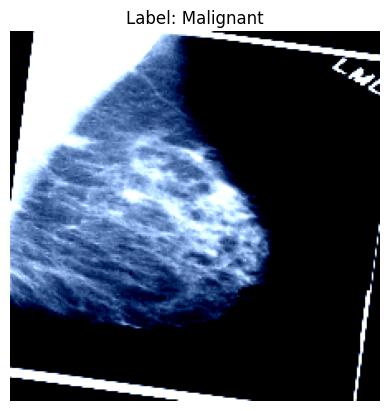

In [ ]:
# @title Quick Check To verify a few image-label pairs:
import matplotlib.pyplot as plt
import numpy as np  # <-- make sure this is here

img, label = train_dataset[0]
plt.imshow(img.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
plt.title(f"Label: {'Malignant' if label==1 else 'Benign'}")
plt.axis('off')
plt.show()



In [ ]:
# @title STEP 3: ViT-Small Training Pipeline

3.1 Install Needed Packages

In [ ]:
!pip install -q timm pytorch-lightning torchmetrics


In [ ]:
# @title 3.2 LightningModule for ViT-Small
import torch
import torch.nn as nn
import pytorch_lightning as pl
import timm
import torchmetrics

class ViTSmallClassifier(pl.LightningModule):
    def __init__(self, num_classes=2, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()

        # Load pretrained ViT-Small
        self.model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=num_classes)

        # Loss function
        self.criterion = nn.CrossEntropyLoss()

        # Metrics
        self.train_acc = torchmetrics.classification.Accuracy(task="binary")
        self.val_acc = torchmetrics.classification.Accuracy(task="binary")
        self.val_f1  = torchmetrics.classification.F1Score(task="binary")
        self.val_auc = torchmetrics.classification.AUROC(task="binary")

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)

        self.train_acc(preds, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:,1]  # for AUC

        # Update metrics
        self.val_acc(preds, y)
        self.val_f1(preds, y)
        self.val_auc(probs, y)

        # Log
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", self.val_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_f1", self.val_f1, on_step=False, on_epoch=True)
        self.log("val_auc", self.val_auc, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}


This saves the model with best validation AUC:

In [ ]:
# @title 💾 3.3 Add ModelCheckpoint Callback

from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor="val_auc",
    mode="max",
    save_top_k=1,
    dirpath="vit_small_checkpoints",
    filename="vit-small-best-{epoch:02d}-{val_auc:.4f}"
)


In [ ]:
# @title 3.4 Train the Model
from pytorch_lightning import Trainer

model = ViTSmallClassifier()

trainer = Trainer(
    max_epochs=10,
    accelerator="auto",
    devices=1,
    callbacks=[checkpoint_callback],
    log_every_n_steps=10
)

trainer.fit(model, train_loader, val_loader)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | VisionTransformer | 21.7 M | train
1 | criterion | CrossEntropyLoss  | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
4 | val_f1    | BinaryF1Score     | 0      | train
5 | val_auc   | BinaryAUROC       | 0      | train
--------------------------------------------------------
21.7 M    Trainable params
0         Non-trainable params
21.7 M    Total params
86.666    Total estimated model params size (MB)
281       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# @title 3.5 Load Best Model Later
best_model = ViTSmallClassifier.load_from_checkpoint(checkpoint_callback.best_model_path)


In [ ]:
# @title STEP 4: Grad-CAM Visualizations for Explainability

 4.1 Install GradCAM Library

In [ ]:
!pip install -q grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# 4.2 Understanding GradCAM
# GradCAM works by using:

# Final convolutional layer output

# Predicted class

# And computing gradients w.r.t. feature

In [ ]:
# @title 4.3 GradCAM Code for ViT-Small
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

# Get the final attention layer for ViT-Small
target_layer = best_model.model.blocks[-1].norm1  # or .norm2 for some ViT variants

# Initialize GradCAM (no use_cuda arg anymore)
cam = GradCAM(model=best_model.model, target_layers=[target_layer])


In [ ]:
!pip install -q grad-cam


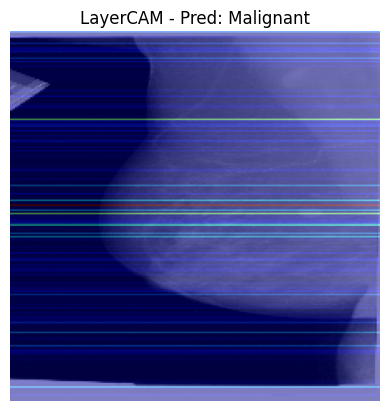

In [ ]:
# @title 4.4 Function to Visualize GradCAM
from pytorch_grad_cam import LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

# 📍 Use last ViT block norm1 (or norm2) — works well
target_layer = best_model.model.blocks[-1].norm1

# ✅ Use LayerCAM which is more ViT-friendly
cam = LayerCAM(model=best_model.model, target_layers=[target_layer])

# 🖼️ Pick an image
img_tensor, label = test_dataset[0]
input_tensor = img_tensor.unsqueeze(0).to(best_model.device)

# 🧠 Prediction
output = best_model(input_tensor)
pred_class = output.argmax(dim=1).item()

# 🔍 Generate CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])[0]

# 🎨 Convert image for overlay
rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy()
rgb_img = np.clip(rgb_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

# 🔥 Overlay CAM
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# 📊 Plot
plt.imshow(cam_image)
plt.title(f"LayerCAM - Pred: {'Malignant' if pred_class == 1 else 'Benign'}")
plt.axis('off')
plt.show()


In [ ]:
# @title 5. Evaluation Metrics in PyTorch Lightning
import torchmetrics

class ViTSmallClassifier(pl.LightningModule):
    def __init__(self, num_classes=2, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()

        self.model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=num_classes)
        self.criterion = nn.CrossEntropyLoss()

        # Metrics
        self.train_acc = torchmetrics.classification.Accuracy(task="binary")
        self.val_acc = torchmetrics.classification.Accuracy(task="binary")
        self.val_f1 = torchmetrics.classification.F1Score(task="binary")
        self.val_precision = torchmetrics.classification.Precision(task="binary")
        self.val_recall = torchmetrics.classification.Recall(task="binary")
        self.val_auc = torchmetrics.classification.AUROC(task="binary")

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]

        self.val_acc(preds, y)
        self.val_f1(preds, y)
        self.val_precision(preds, y)
        self.val_recall(preds, y)
        self.val_auc(probs, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_acc, prog_bar=True)
        self.log("val_f1", self.val_f1, prog_bar=True)
        self.log("val_precision", self.val_precision)
        self.log("val_recall", self.val_recall)
        self.log("val_auc", self.val_auc)

        return loss


In [ ]:
# @title 5.1. Train or Validate the Model

In [ ]:
trainer.validate(best_model, dataloaders=val_loader)


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.6869918704032898     │
│          val_auc          │    0.7891892790794373     │
│          val_f1           │    0.7049808502197266     │
│         val_loss          │    0.5727617740631104     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.5727617740631104,
  'val_acc': 0.6869918704032898,
  'val_f1': 0.7049808502197266,
  'val_auc': 0.7891892790794373}]

In [ ]:
# @title 5.2 Print Metrics After Validation
def evaluate_model(model, dataloader):
    model.eval()
    acc = torchmetrics.classification.Accuracy(task="binary").to(model.device)
    f1 = torchmetrics.classification.F1Score(task="binary").to(model.device)
    precision = torchmetrics.classification.Precision(task="binary").to(model.device)
    recall = torchmetrics.classification.Recall(task="binary").to(model.device)
    auc = torchmetrics.classification.AUROC(task="binary").to(model.device)

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(model.device)
            y = y.to(model.device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            probs = torch.softmax(logits, dim=1)[:, 1]

            acc.update(preds, y)
            f1.update(preds, y)
            precision.update(preds, y)
            recall.update(preds, y)
            auc.update(probs, y)

    print(f"Accuracy:  {acc.compute().item():.4f}")
    print(f"F1 Score:  {f1.compute().item():.4f}")
    print(f"Precision: {precision.compute().item():.4f}")
    print(f"Recall:    {recall.compute().item():.4f}")
    print(f"AUC:       {auc.compute().item():.4f}")

# Run it
evaluate_model(best_model, val_loader)


Accuracy:  0.6870
F1 Score:  0.7050
Precision: 0.6133
Recall:    0.8288
AUC:       0.7892


In [ ]:
# @title 5.3 STEP-BY-STEP: Plot ROC, PR, Confusion Matrix in High Resolution

In [ ]:
# @title 5.3.1 Collect Predictions and Ground Truth
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Step 1: Collect all predictions
def get_preds(model, dataloader):
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(model.device)
            y = y.to(model.device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

y_true, y_pred, y_prob = get_preds(best_model, val_loader)


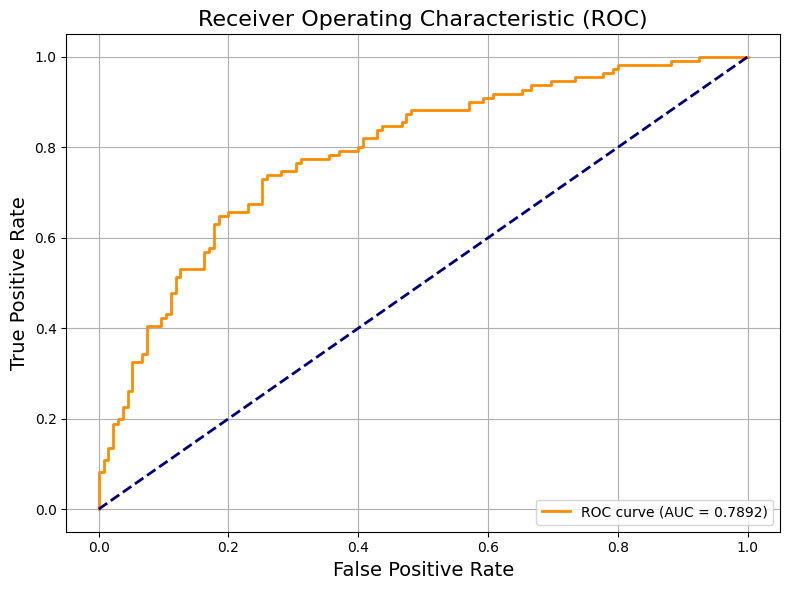

In [ ]:
# @title 5.3.2 Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve.png", dpi=300)
plt.show()


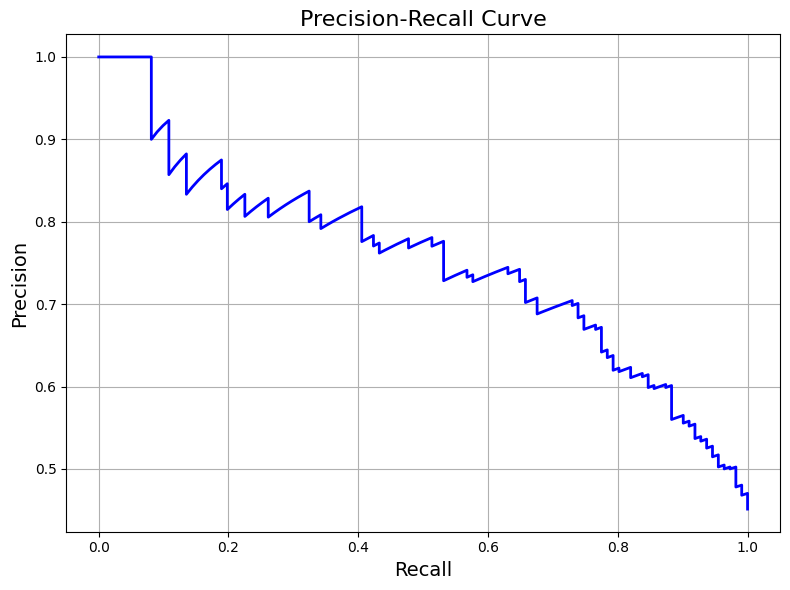

In [ ]:
# @title 5.3.3 Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_prob)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig("precision_recall_curve.png", dpi=300)
plt.show()


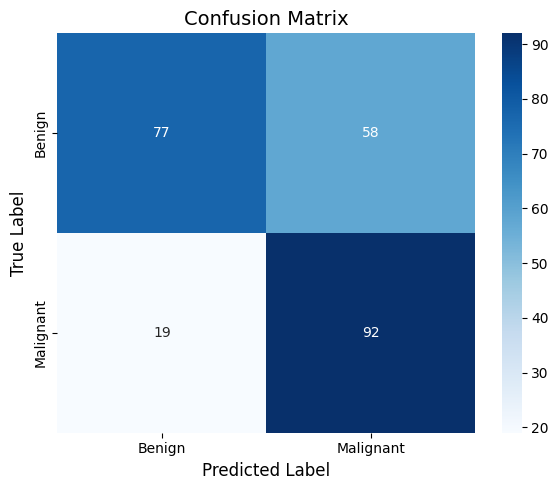

In [ ]:
# @title 5.3.4 Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = ['Benign', 'Malignant']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()


In [ ]:
# @title # ✅ GradCAM + ViT-Small Full Pipeline (Colab Ready)

In [ ]:
# ✅ GradCAM + ViT-Small Full Pipeline (Colab Ready)

# 📦 1. Install dependencies
!pip install -q albumentations timm pytorch-lightning torchmetrics grad-cam

# ✅ 2. Imports
import os
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
import timm
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchmetrics

# ✅ 3. Mammogram Dataset
class MammogramDataset(Dataset):
    def __init__(self, image_paths, labels, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.augment = augment

        self.train_transforms = A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Rotate(limit=10, p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

        self.val_transforms = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        if self.augment:
            image = self.train_transforms(image=image)['image']
        else:
            image = self.val_transforms(image=image)['image']

        return image, torch.tensor(label, dtype=torch.long)

# ✅ 4. ViT-Small Lightning Module
class ViTSmallClassifier(pl.LightningModule):
    def __init__(self, num_classes=2, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.classification.Accuracy(task="binary")
        self.val_acc = torchmetrics.classification.Accuracy(task="binary")
        self.val_f1 = torchmetrics.classification.F1Score(task="binary")
        self.val_auc = torchmetrics.classification.AUROC(task="binary")

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_acc(preds, y)
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", self.train_acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:,1]
        self.val_acc(preds, y)
        self.val_f1(preds, y)
        self.val_auc(probs, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", self.val_acc, on_epoch=True, prog_bar=True)
        self.log("val_f1", self.val_f1, on_epoch=True)
        self.log("val_auc", self.val_auc, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# ✅ 5. Training Setup (assuming train_loader, val_loader ready)
checkpoint_callback = ModelCheckpoint(
    monitor="val_auc",
    mode="max",
    save_top_k=1,
    dirpath="vit_small_checkpoints",
    filename="vit-small-best-{epoch:02d}-{val_auc:.4f}"
)

model = ViTSmallClassifier()
trainer = pl.Trainer(max_epochs=10, accelerator="auto", devices=1, callbacks=[checkpoint_callback], log_every_n_steps=10)
trainer.fit(model, train_loader, val_loader)

# ✅ 6. Load best model
best_model = ViTSmallClassifier.load_from_checkpoint(checkpoint_callback.best_model_path)

# ✅ 7. GradCAM Setup
cam = GradCAM(model=best_model.model, target_layers=[best_model.model.blocks[-1].norm1], use_cuda=torch.cuda.is_available())

# ✅ 8. Visualize GradCAM

def visualize_gradcam(img_tensor, label, model, cam_obj):
    input_tensor = img_tensor.unsqueeze(0).to(model.device)
    rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy()
    rgb_img = np.clip(rgb_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    grayscale_cam = cam_obj(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])[0]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(rgb_img)
    plt.title(f"Original\nLabel: {'Malignant' if label==1 else 'Benign'}")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(visualization)
    plt.title(f"GradCAM\nPredicted: {'Malignant' if pred_class==1 else 'Benign'}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# ✅ 9. Run GradCAM on test image
img_tensor, label = test_dataset[3]  # Change index as needed
visualize_gradcam(img_tensor, label, best_model, cam)


In [ ]:
# @title
import os

# Directory to save GradCAM outputs
os.makedirs("gradcam_outputs", exist_ok=True)

def save_gradcam_batch(dataset, model, cam_obj, num_images=10):
    for i in range(num_images):
        img_tensor, label = dataset[i]
        input_tensor = img_tensor.unsqueeze(0).to(model.device)
        rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy()
        rgb_img = np.clip(rgb_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()
        grayscale_cam = cam_obj(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])[0]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        filename = f"gradcam_outputs/img_{i}_label_{label}_pred_{pred_class}.png"
        cv2.imwrite(filename, cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR))

        print(f"Saved: {filename}")


In [ ]:
# @title

In [ ]:
save_gradcam_batch(test_dataset, best_model, cam, num_images=10)


Saved: gradcam_outputs/img_0_label_0_pred_1.png
Saved: gradcam_outputs/img_1_label_1_pred_1.png
Saved: gradcam_outputs/img_2_label_1_pred_1.png
Saved: gradcam_outputs/img_3_label_1_pred_1.png
Saved: gradcam_outputs/img_4_label_1_pred_1.png
Saved: gradcam_outputs/img_5_label_0_pred_1.png
Saved: gradcam_outputs/img_6_label_1_pred_1.png
Saved: gradcam_outputs/img_7_label_0_pred_0.png
Saved: gradcam_outputs/img_8_label_1_pred_1.png
Saved: gradcam_outputs/img_9_label_1_pred_1.png


In [ ]:
!pip install -q captum


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 34.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/usr/local/lib/python3.11/dist-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


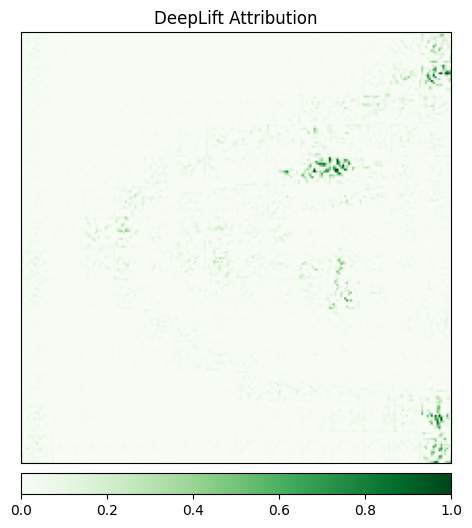

(<Figure size 600x600 with 2 Axes>,
 <Axes: title={'center': 'DeepLift Attribution'}>)

In [ ]:
# @title
from captum.attr import DeepLift
from captum.attr import visualization as viz

# Use DeepLift instead of DeepLiftShap
shap = DeepLift(best_model)

# Get one sample
input_tensor, label = test_dataset[3]
input_tensor = input_tensor.unsqueeze(0).to(best_model.device)

# Use zero baseline or a blurred mean image (for better results later)
baseline = torch.zeros_like(input_tensor).to(best_model.device)

# Compute attributions
shap_vals = shap.attribute(input_tensor, baselines=baseline, target=label)

# Convert for visualization
shap_np = shap_vals.squeeze().cpu().detach().numpy().transpose(1, 2, 0)

# Show SHAP heatmap
viz.visualize_image_attr(
    shap_np,
    method="heat_map",
    sign="positive",
    show_colorbar=True,
    title="DeepLift Attribution"
)


# Correct Model Names for ViT and RegNet in timm

In [ ]:
# @title ViT (Vision Transformer) Models:
import timm

# ViT-Small
vit_small = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=2)

# ViT-Base (as Medium)
vit_medium = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)

# ViT-Large
vit_large = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=2)

# RegNetY - use 064 as closest to 050
regnet = timm.create_model('regnety_064', pretrained=True, num_classes=2)


model.safetensors:   0%|          | 0.00/123M [00:00<?, ?B/s]

In [ ]:
# @title GradCAM Target Layer Selection
import timm

# ViT Target Layer
vit_model = timm.create_model('vit_small_patch16_224', pretrained=True)
vit_target_layers = [vit_model.blocks[-1].norm1]  # ✅ Works for ViT

# RegNet Target Layer (access last block from s4 properly)
regnet_model = timm.create_model('regnety_064', pretrained=True)

# Print structure to inspect what’s inside s4
# print(list(regnet_model.s4.children()))

# Get last block using next(reversed(...)) pattern
last_s4_block = next(reversed(list(regnet_model.s4.children())))
regnet_target_layers = [last_s4_block]  # ✅ Works for GradCAM


In [ ]:
# @title Building the ViT + RegNet fusion model
# For ViT
vit_target_layers = [vit_model.blocks[-1].norm1]

# For RegNetY
regnet_target_layers = [next(reversed(list(regnet_model.s4.children())))]


In [ ]:
# @title For RegNet (e.g. 'regnety_064'):

In [ ]:

target_layers = [model.stem]  # Or last conv block, e.g., model.s3[-1]


In [ ]:
# @title Fixing the ViT + RegNet Fusion Model

In [ ]:
class ViT_RegNet_Fusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=0)
        self.regnet = timm.create_model('regnety_050', pretrained=True, num_classes=0)
        self.head = nn.Sequential(
            nn.Linear(self.vit.num_features + self.regnet.num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        vit_feat = self.vit.forward_features(x)
        regnet_feat = self.regnet.forward_features(x)
        combined = torch.cat((vit_feat, regnet_feat), dim=1)
        return self.head(combined)


In [ ]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 33.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
captum 0.8.0 requires numpy<2.0, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.


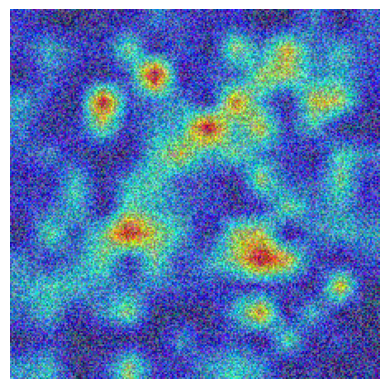

In [ ]:
# @title Minimal ViT GradCAM example with reshape transform

import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
import timm

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=2).to(device)
model.eval()

def vit_reshape_transform(tensor):
    # Remove class token and reshape for GradCAM
    batch_size, n_tokens, hidden_dim = tensor.size()
    height = width = int((n_tokens - 1) ** 0.5)  # sqrt of patch count
    result = tensor[:, 1:, :].reshape(batch_size, height, width, hidden_dim)
    return result.permute(0, 3, 1, 2)  # (B, C, H, W)

target_layers = [model.blocks[-1].norm1]

cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=vit_reshape_transform)

# Dummy input (replace with your real normalized image tensor)
input_tensor = torch.rand(1, 3, 224, 224).to(device)

output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])
grayscale_cam = grayscale_cam[0]

original_img = input_tensor[0].permute(1, 2, 0).cpu().numpy()
original_img = np.clip(original_img, 0, 1)

cam_image = show_cam_on_image(original_img, grayscale_cam, use_rgb=True)

plt.imshow(cam_image)
plt.axis('off')
plt.show()


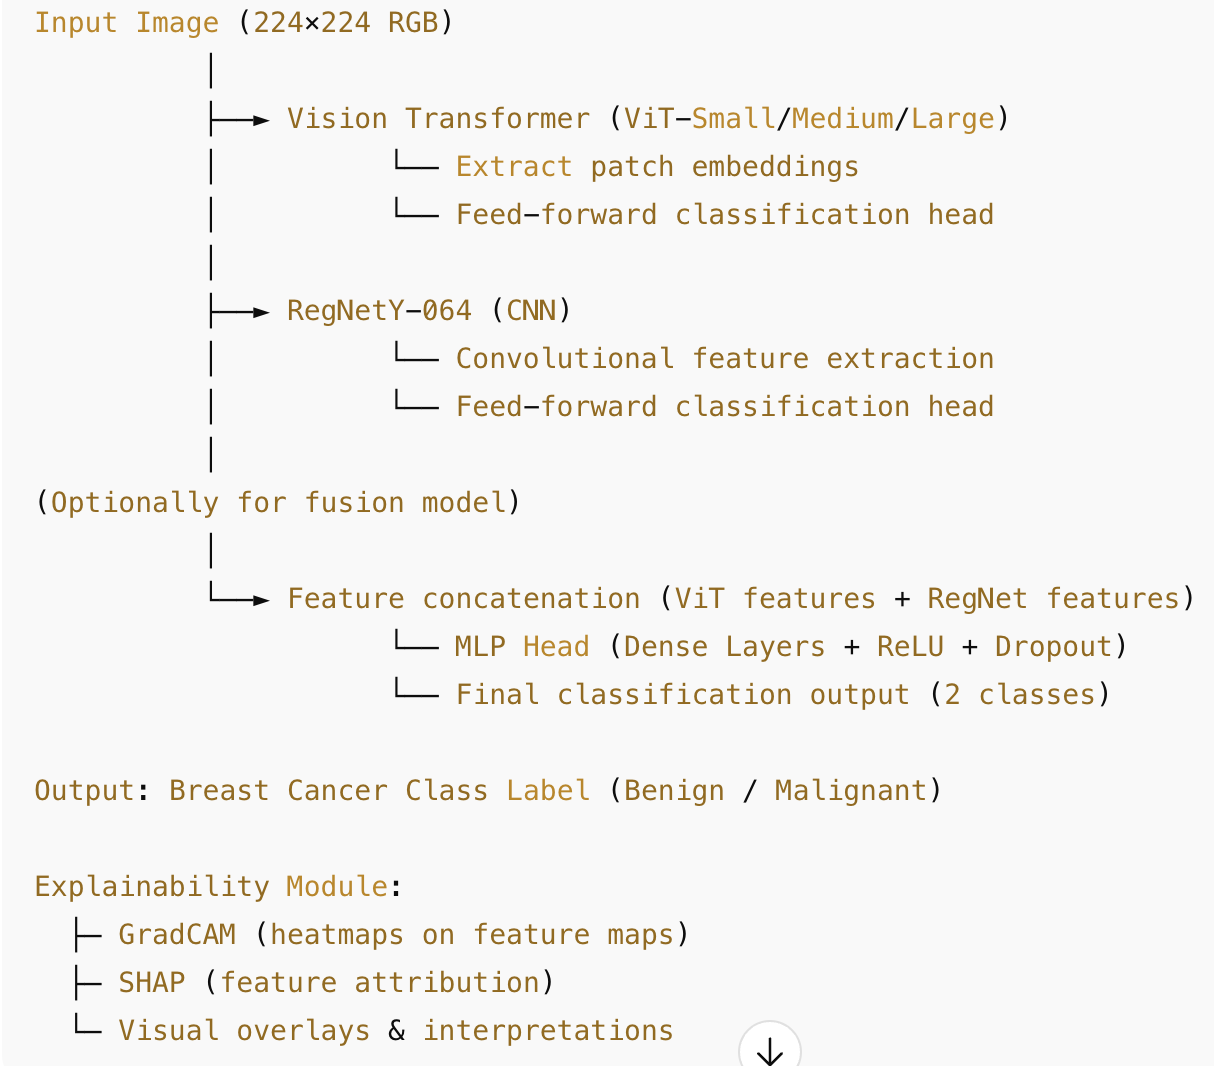